In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

In [2]:
model = VGG16(weights='imagenet')

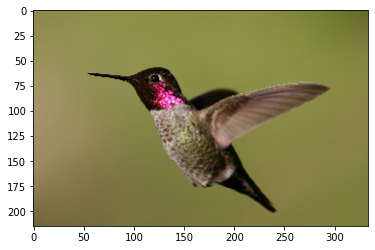

In [3]:
img_path = 'drive/My Drive/Tesi/Colab Notebooks/hummingbird.jpg'
img=mpimg.imread(img_path)
plt.imshow(img)

In [4]:
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(224,224))

In [5]:
x = image.img_to_array(img)

In [6]:
import numpy as np
x=np.expand_dims(x, axis=0)

In [7]:
x.shape

(1, 224, 224, 3)

In [8]:
from keras.applications.vgg16 import preprocess_input
x=preprocess_input(x)

In [9]:
x

array([[[[-24.939003 ,  17.221    ,  17.32     ],
         [-22.939003 ,  19.221    ,  19.32     ],
         [-27.939003 ,  17.221    ,  16.32     ],
         ...,
         [-64.939    , -10.778999 , -24.68     ],
         [-64.939    , -11.778999 , -23.68     ],
         [-64.939    , -12.778999 , -21.68     ]],

        [[-22.939003 ,  19.221    ,  19.32     ],
         [-22.939003 ,  19.221    ,  19.32     ],
         [-25.939003 ,  19.221    ,  18.32     ],
         ...,
         [-63.939003 ,  -9.778999 , -23.68     ],
         [-63.939003 , -10.778999 , -22.68     ],
         [-63.939003 , -11.778999 , -20.68     ]],

        [[-23.939003 ,  18.221    ,  18.32     ],
         [-22.939003 ,  19.221    ,  19.32     ],
         [-23.939003 ,  21.221    ,  19.32     ],
         ...,
         [-63.939003 , -10.778999 , -22.68     ],
         [-63.939003 , -10.778999 , -22.68     ],
         [-65.939    , -12.778999 , -24.68     ]],

        ...,

        [[-45.939003 , -13.778999 ,  -

In [10]:
import pandas as pd
from keras.applications.vgg16 import decode_predictions
preds=model.predict(x)
predictions=pd.DataFrame(decode_predictions(preds, top=3)[0], columns=['col1','category','probability']).iloc[:,1:]
print('PREDICTION:',predictions.loc[0,'category'])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
PREDICTION: hummingbird


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Top 3 Predictions:')

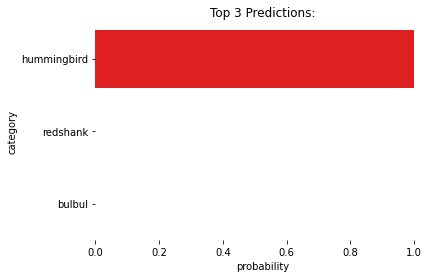

In [11]:
import seaborn as sns
f=sns.barplot(x='probability',y='category',data=predictions,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

In [12]:
argmax=np.argmax(preds[0])

In [13]:
output=model.output[:,argmax]

In [14]:
model.layers

In [15]:
last_conv_layer=model.get_layer('block5_conv3')

In [16]:
grads = K.gradients(output, last_conv_layer.output)[0]

In [17]:
pooled_grads = K.mean(grads, axis=(0,1,2))

In [18]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [19]:
pooled_grads_value, conv_layer_output_value = iterate([x])

In [20]:
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

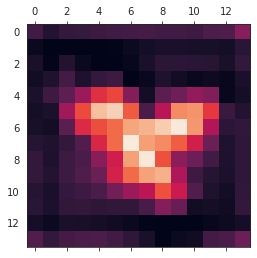

In [21]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [22]:
import cv2
img = cv2.imread(img_path)

In [23]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

In [24]:
heatmap = np.uint8(255 * heatmap)

In [25]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [26]:
hif = .8

In [27]:
superimposed_img = heatmap * hif + img

In [28]:
output = 'drive/My Drive/Tesi/Colab Notebooks/output.jpeg'
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

Text(0.5, 1.0, 'hummingbird')

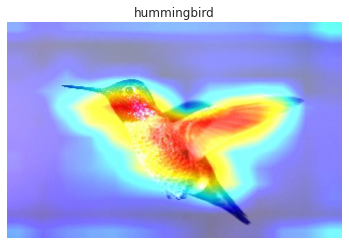

In [29]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])

In [30]:
def cam(img_path):
    from keras.applications.vgg16 import VGG16
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    %matplotlib inline
    K.clear_session()
    
    model = VGG16(weights='imagenet')
    img=mpimg.imread(img_path)
    plt.imshow(img)
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    from keras.applications.vgg16 import preprocess_input
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = 'drive/My Drive/Tesi/Colab Notebooks/output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

In [31]:
cam('G:/sample1.jpg')

FileNotFoundError: ignored

In [ ]:
cam('G:/sample2.jpg')

In [ ]:
cam('G:/sample3.jpg')

In [ ]:
cam('G:/greater_swiss_mountain_dog.jpg')

In [ ]:
cam('G:/greater_swiss_mountain_dog4.jpg')

In [ ]:
cam('G:/greater_swiss_mountain_dog2.jpg')

In [ ]:
cam('G:/greater_swiss_mountain_dog3.jpg')

In [ ]:
cam('G:/african_hunting_dog.jpg')

In [ ]:
cam('G:/bernese_mountain_dog.jpg')

In [ ]:
cam('G:/french_bulldog2.jpg')

In [ ]:
cam('G:/Maltese_puppy.jpeg')

In [ ]:
cam('drive/My Drive/Tesi/Colab Notebooks/test.jpg')

In [ ]:
cam('drive/My Drive/Tesi/Colab Notebooks/baba.jpg')

In [ ]:
cam('drive/My Drive/Tesi/Colab Notebooks/elefante.jpg')

In [ ]:
cam('drive/My Drive/Tesi/Colab Notebooks/computer.jpg')